In [ ]:
!pip install lpips

In [ ]:
import os
from os.path import join
import numpy as np
from PIL import Image
import torch
from diffusers import ControlNetModel, DDIMScheduler
from pipeline_sync_controlnet import StableDiffusionControlNetPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

### Load pretrained ControlNet model

In [ ]:
# Ex1) QR code monster (https://huggingface.co/monster-labs/control_v1p_sd15_qrcode_monster)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster")

# Ex2) Canny edge map (https://huggingface.co/lllyasviel/sd-controlnet-canny)
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionControlNetPipeline.from_pretrained(model_id, controlnet=controlnet).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

### Load condition input

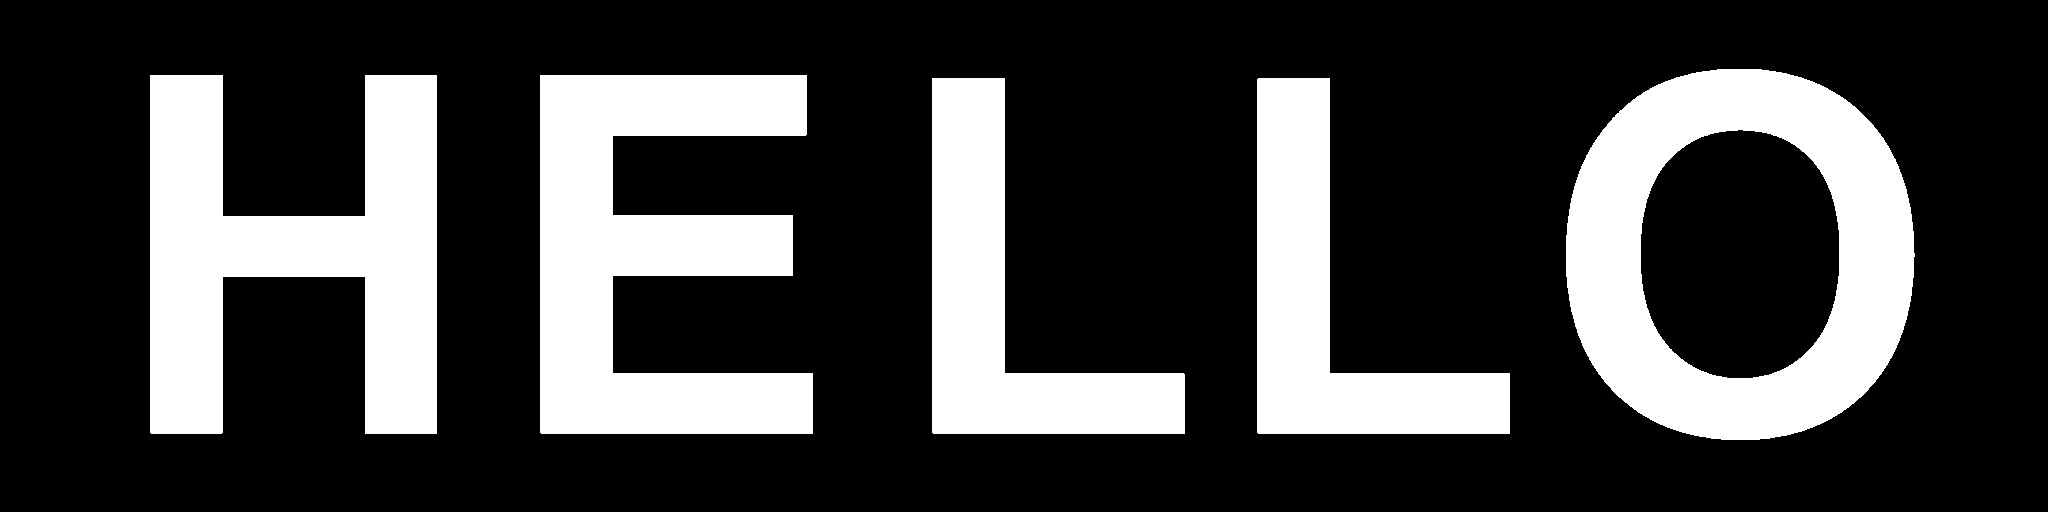

In [3]:
# Ex1) QR code condition
mask_image_full = Image.open(join("assets", "qrcode_hello.png"))

# Ex2) Canny edge map condition
# mask_image_full = Image.open(join("assets", "canny_city_512x3072.png"))
mask_image_full

### Run SyncControlNet
* NOTE: Requires ~20GB of vRAM (tested with 24GB NVIDIA A5000)

[INFO] number of views to process: 13


  0%|          | 0/50 [00:00<?, ?it/s]/home/yuseung07/SyncControl/SyncControlNet/pipeline_sync_controlnet.py:449: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


[INFO] SyncDiffusion sampling finished.


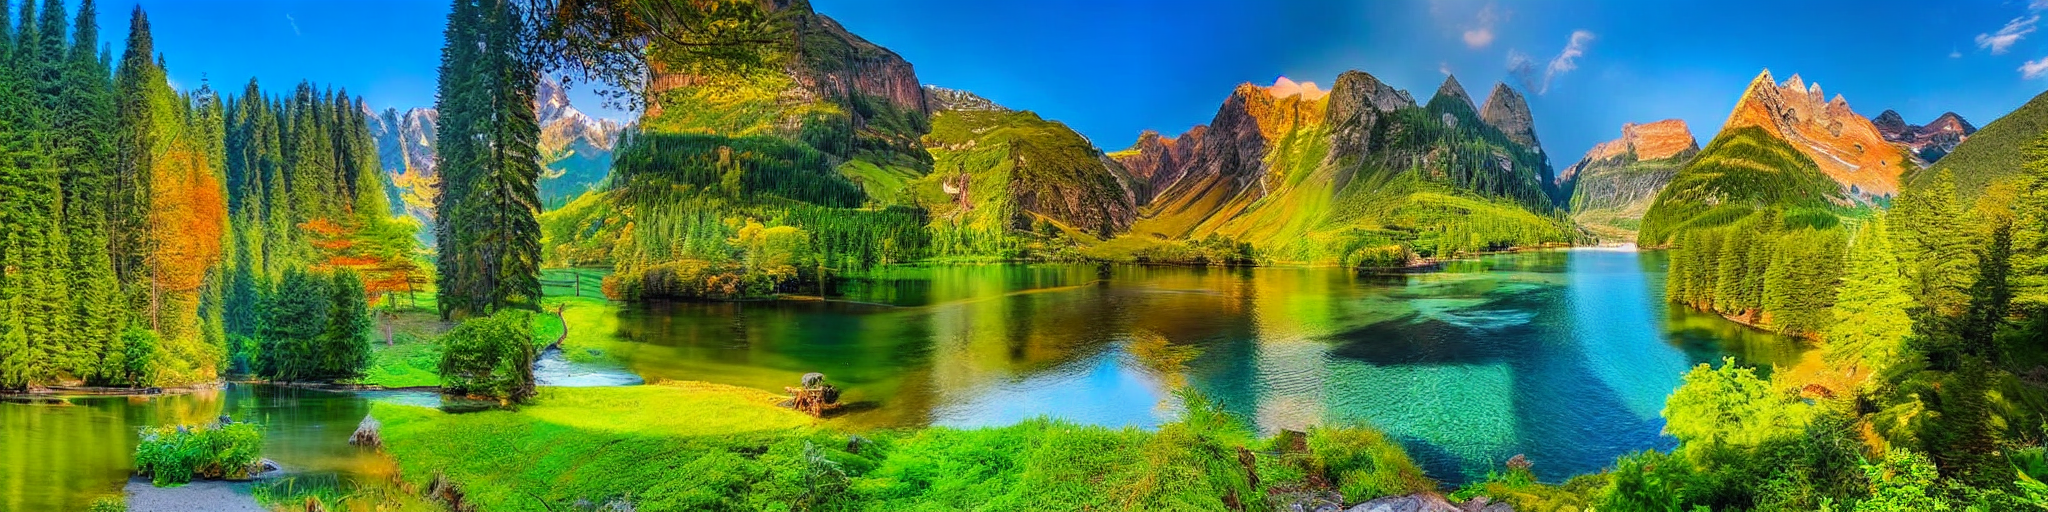

In [4]:
'''
[Some example prompts]
- a beautiful natural landscape, best quality
- a beautiful city on a sunny day in oil painting, best quality
- a beautiful town in a bird's eye view, best quality
- sci-fi_digital_painting_of_a_city_in_a_faraway_planet, best quality
'''

# Set prompt and negative prompt
prompt = "beautiful natural landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

# Set hyperparameters
seed = 0
height = 512
width = 2048
controlnet_conditioning_scale = 1.0

stride = 16             # stride for SyncDiffusion
sync_weight = 20        # gradient descent weight for SyncDiffusion
sync_thres = 5          # threshold step for SyncDiffusion
sync_decay_rate = 0.99  # decay rate for SyncDiffusion

# Create output directory
prompt_name = prompt.replace(" ", "_")
output_dir = join("outputs", prompt_name)
os.makedirs(output_dir, exist_ok=True)

assert width % (8 * stride) == 0 and height % (8 * stride) == 0, "width and height must be divisible by 8 * stride"

# Run inference for SyncControlNet
generator = torch.Generator(device="cpu").manual_seed(seed)
images = [mask_image_full]

image = pipeline(
    prompt,
    images,
    height=height,
    width=width,
    num_inference_steps=50,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    stride=stride, 
    sync_weight=sync_weight, 
    sync_thres=sync_thres, 
    sync_decay_rate=sync_decay_rate,
)

image.save(join(output_dir, f"seed_{seed}.png"))
image